In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import GPy
from BNN_Dropout import NN_Dropout, BNN_Dropout
from Benchmark import RandomNN
from pybnn.bohamiann import Bohamiann

plt.rcParams['figure.figsize'] = (12.0, 8)


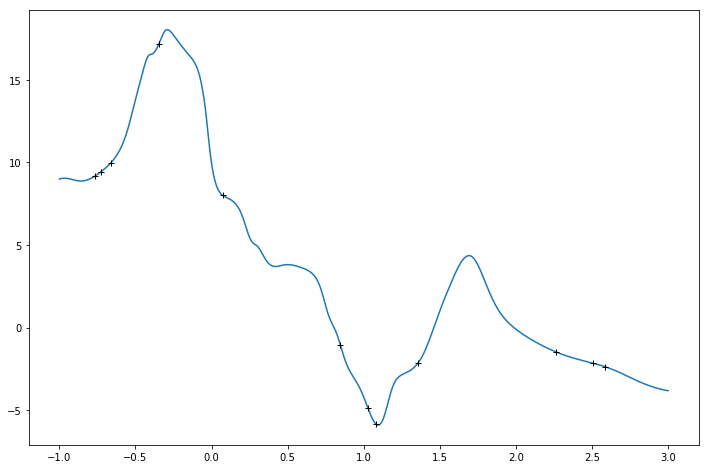

In [17]:
bench = RandomNN(1,3,50,nn.Tanh())
bench.rand_normal_weight(1)
num_plot  = 1000
num_train = 12
x = torch.linspace(-1,3,num_plot)[:,None]
y = bench(x)
train_id = np.random.permutation(num_plot)[:num_train]
train_x = x[train_id]
train_y = y[train_id]
plt.plot(x.numpy(), y.detach().numpy())
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')

In [18]:
conf = dict()
conf['num_epochs'] = 5000
#conf['num_hidden'] = 50
#conf['num_layers'] = 3
#conf['batch_size'] = 1
#conf['lr'] = 1e-4
conf['tau'] = 1e-3
conf['dropout_rate'] = 0.05

model = BNN_Dropout(1,nn.Tanh(), conf)
hmc_model = Bohamiann(print_every_n_steps=100)
kern = GPy.kern.RBF(input_dim = 1)
gp = GPy.models.GPRegression(X=train_x.numpy(), Y= train_y.detach().numpy(), kernel=kern)
gp.likelihood.variance = 1e-2

In [19]:
hmc_model.train(train_x.numpy(), train_y.detach().numpy(), num_steps=3000, num_burn_in_steps=2000, keep_every=50, lr=1e-2, verbose=True)
model.train(train_x, train_y)
gp.optimize()

Step      100 : NLL =  9.1151e+02 MSE = 9.5790e+01 Time =  0.33
Step      200 : NLL =  1.1438e+03 MSE = 1.0083e+02 Time =  0.61
Step      300 : NLL =  1.3948e+03 MSE = 1.0110e+02 Time =  0.89
Step      400 : NLL =  1.7109e+03 MSE = 1.0151e+02 Time =  1.19
Step      500 : NLL =  2.0907e+03 MSE = 1.0101e+02 Time =  1.48
Step      600 : NLL =  2.6444e+03 MSE = 1.0165e+02 Time =  1.90
Step      700 : NLL =  3.2497e+03 MSE = 1.0048e+02 Time =  2.24
Step      800 : NLL =  4.0098e+03 MSE = 1.0160e+02 Time =  2.64
Step      900 : NLL =  4.9563e+03 MSE = 1.0087e+02 Time =  2.92
Step     1000 : NLL =  6.0253e+03 MSE = 1.0221e+02 Time =  3.20
Step     1100 : NLL =  7.3135e+03 MSE = 1.0170e+02 Time =  3.49
Step     1200 : NLL =  8.8655e+03 MSE = 1.0162e+02 Time =  3.77
Step     1300 : NLL =  1.0840e+04 MSE = 1.0197e+02 Time =  4.06
Step     1400 : NLL =  1.3452e+04 MSE = 1.0253e+02 Time =  4.35
Step     1500 : NLL =  1.6756e+04 MSE = 1.0182e+02 Time =  4.64
Step     1600 : NLL =  1.9992e+04 MSE = 

 /mnt/c/code/pybnn/pybnn/bohamiann.py:119: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Step     2100 : NLL =  4.0202e+04 MSE = 1.0305e+02 Samples= 1 Time =  6.31
Step     2200 : NLL =  2.9055e+03 MSE = 1.0485e+02 Samples= 3 Time =  6.57
Step     2300 : NLL =  4.0946e+03 MSE = 1.0360e+02 Samples= 5 Time =  6.81
Step     2400 : NLL =  5.1561e+03 MSE = 1.0305e+02 Samples= 7 Time =  7.06
Step     2500 : NLL =  6.1297e+03 MSE = 1.0275e+02 Samples= 9 Time =  7.31
Step     2600 : NLL =  6.4932e+03 MSE = 1.0257e+02 Samples= 11 Time =  7.55
Step     2700 : NLL =  6.8531e+03 MSE = 1.0245e+02 Samples= 13 Time =  7.79
Step     2800 : NLL =  6.9847e+03 MSE = 1.0232e+02 Samples= 15 Time =  8.04
Step     2900 : NLL =  7.2783e+03 MSE = 1.0224e+02 Samples= 17 Time =  8.29
After 101 epochs, loss is 9.4789
After 201 epochs, loss is 4.25787
After 301 epochs, loss is 2.37105
After 401 epochs, loss is 2.3497
After 501 epochs, loss is 2.29599
After 601 epochs, loss is 2.1302
After 701 epochs, loss is 2.14363
After 801 epochs, loss is 1.57331
After 901 epochs, loss is 1.52366
After 1001 epochs,

Text(0.5,1,'Gaussian process')

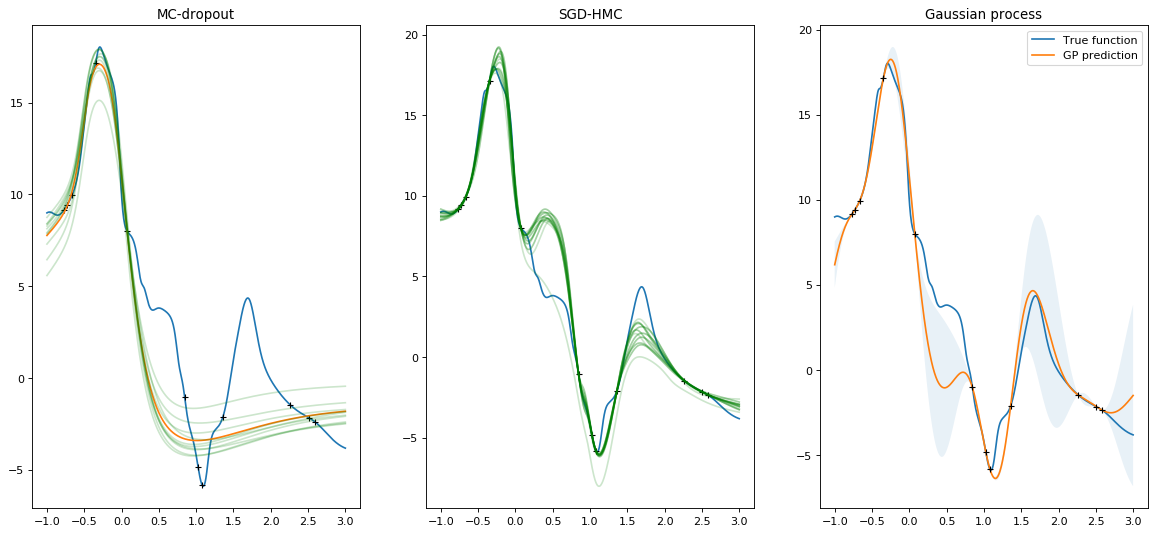

In [20]:
py = model.predict(x)
_,_,hmc_py = hmc_model.predict(x.numpy(), return_individual_predictions=True)
fig=plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')


plt.subplot(131)
plt.plot(x.numpy(), y.detach().numpy())
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.plot(x.numpy(),py.detach().numpy(),label = 'Pred')
for i in range(10):
    net = model.sample()
    py  = net(x)
    plt.plot(x.numpy(),py.detach().numpy(), 'g', alpha = 0.2)
plt.title('MC-dropout')

plt.subplot(132)
plt.plot(x.numpy(), y.detach().numpy())
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.plot(x.numpy(), hmc_py.T, 'g', alpha = 0.2)
plt.title('SGD-HMC')

plt.subplot(133)
gp_m, gp_v = gp.predict(x.numpy())
plt.plot(x.numpy(), y.detach().numpy(), label = 'True function')
plt.plot(x.numpy(), gp_m, label = 'GP prediction')
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.fill_between(x.numpy().reshape(num_plot), (gp_m - np.sqrt(gp_v)).reshape(num_plot), (gp_m + np.sqrt(gp_v)).reshape(num_plot), alpha = 0.1)
plt.legend()
plt.title('Gaussian process')